In [1]:
import numpy as np, pylab,sys
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit

%matplotlib inline  
bolshoi_particle_mass = 1.35E8 # Msun/h

In [2]:
def get_stats(log_mass,conc, bins):
    median_conc = np.empty(len(bins)-1)
    quar1_conc = np.empty(len(bins)-1)
    quar2_conc = np.empty(len(bins)-1)

    for i in range(len(bins)-1):
        mass_index = np.where((log_mass>bins[i]) & (log_mass<bins[i+1]))
        if(np.size(mass_index)>1):
            conc_index = conc[mass_index]
            print np.size(mass_index)
            median_conc[i] = np.percentile(conc_index, 50)
            quar1_conc[i] = np.percentile(conc_index, 25)
            quar2_conc[i] = np.percentile(conc_index, 75)
        else:
            median_conc[i] = median_conc[i-1]
            quar1_conc[i] = quar1_conc[i-1]
            quar2_conc[i] = quar2_conc[i-1]
                                      
    return median_conc,quar1_conc,quar2_conc

def enlarge_labels(ax,fsize):
    ticklabels_x = ax.get_xticklabels()
    ticklabels_y = ax.get_yticklabels()

    for label_x in ticklabels_x:
        label_x.set_fontsize(fsize)
        label_x.set_family('serif')
    for label_y in ticklabels_y:
        label_y.set_fontsize(fsize)
        label_y.set_family('serif')

## Results form mock halos

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


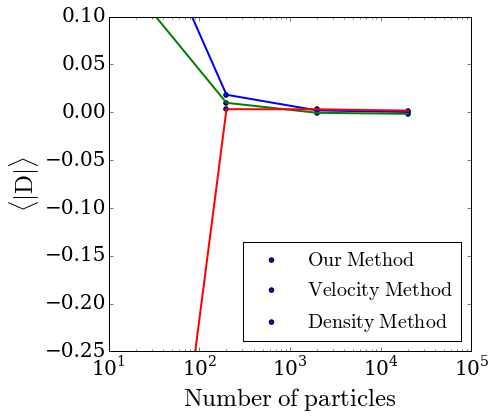

In [3]:
mass = np.loadtxt('../data/results/mock/mock_100/newMass/table.csv',delimiter=',')
vlct = np.loadtxt('../data/results/mock/mock_100/velocity/table.csv',delimiter=',')
dens = np.loadtxt('../data/results/mock/mock_100/newDensity/table.csv',delimiter=',')

def chi2(x_obs,x_org):
    return np.max(x_obs/x_org - 1.0)


orig = vlct[:,0]
chi_vlct = np.array([chi2(orig,vlct[:,1]),chi2(orig,vlct[:,2]),chi2(orig,vlct[:,3]),chi2(orig,vlct[:,4])])

orig = mass[:,0]
chi_mass = np.array([chi2(orig,mass[:,1]),chi2(orig,mass[:,2]),chi2(orig,mass[:,3]),chi2(orig,mass[:,4])])

orig = vlct[:,0]
chi_dens = np.array([chi2(orig,dens[:,0]),chi2(orig,dens[:,1]),chi2(orig,dens[:,2]),chi2(orig,dens[:,3])])

fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

plt.plot([20,200,2000,20000],chi_mass,lw=2)
plt.scatter([20,200,2000,20000],chi_mass,label='$\mathrm{Our\ Method}$')
plt.plot([20,200,2000,20000],chi_vlct,lw=2)
plt.scatter([20,200,2000,20000],chi_vlct,label='$\mathrm{Velocity\ Method}$')
plt.plot([20,200,2000,20000],chi_dens,lw=2)
plt.scatter([20,200,2000,20000],chi_dens,label='$\mathrm{Density\ Method}$')
plt.xscale('log')
#plt.yscale('log')
plt.xlim([10,1E5])
plt.ylim([-0.25, 0.1])

plt.xlabel('$\mathrm{Number\ of\ particles}$',fontsize=25)
plt.ylabel('$\mathrm{\langle|D|\\rangle}$',fontsize=25)

ax.legend(loc=4, scatterpoints=1, prop={'size':20})
plt.savefig('error.png',dpi=200)
plt.savefig('error.pdf',dpi=200)


# Downsampling statistics for Bolshoi

In [4]:
sample_path = '/home/forero/github/MACH/data/results/BolshoiDownsample/'
dens_files = glob.glob(sample_path+"results_dens*.dat")
dens_files.sort()
mass_files = glob.glob(sample_path+"results_mass*.csv")
mass_files.sort()
vlct_files = glob.glob(sample_path+"results_vlct*.csv")
vlct_files.sort()

In [5]:
def gather_data(files_dens, files_vlct, files_mass):
    dens_conc = np.empty(0)
    vlct_conc = np.empty(0)
    mass_conc = np.empty(0)
    n_part = np.empty(0)
    r_vir = np.empty(0)
    for file_dens, file_vlct, file_mass in zip(files_dens, files_vlct, files_mass):
        dens_data = np.loadtxt(file_dens)
        vlct_data = np.loadtxt(file_vlct, skiprows=1, delimiter=',')
        mass_data = np.loadtxt(file_mass, skiprows=1, delimiter=',')
    
        norm_dens_conc = np.median(vlct_data[-100:,3]/dens_data[-100:,1])
        print norm_dens_conc
        dens_conc = np.append(dens_conc, vlct_data[:,3]/dens_data[:,1]/norm_dens_conc - 1.0)
        
        norm_vlct_conc = np.median(vlct_data[-100:,1])
        vlct_conc = np.append(vlct_conc, vlct_data[:,1]/norm_vlct_conc - 1.0)
        
        norm_mass_conc = np.median(mass_data[-100:,2])
        mass_conc = np.append(mass_conc, mass_data[:,2]/norm_mass_conc - 1.0)
        
        n_part = np.append(n_part, vlct_data[:,2])
        #print(np.shape(vlct_conc))
    return dens_conc, vlct_conc, mass_conc, n_part 
        
dens_conc, vlct_conc, mass_conc, n_part = gather_data(dens_files, vlct_files, mass_files)

7.80580148872
5.38874059398
6.70561655654
5.47086102638
5.80110794518
6.22215080239
6.13260648442
4.79231010517
5.92480579323
6.1076045838
5.71937330102
3.73029190703
6.12117006058
6.91534306541


In [6]:
def func(x, a, b):
    return a / (1.0 + x)**b 
    #return a * x ** b


n_int = 11
n_part_space = np.logspace(2.3,5.0,n_int)
print n_part_space

bol_median_dens_conc = np.zeros(n_int-1)
bol_low_dens_conc = np.zeros(n_int-1)
bol_high_dens_conc = np.zeros(n_int-1)


bol_median_vlct_conc = np.zeros(n_int-1)
bol_low_vlct_conc = np.zeros(n_int-1)
bol_high_vlct_conc = np.zeros(n_int-1)

bol_median_mass_conc = np.zeros(n_int-1)
bol_low_mass_conc = np.zeros(n_int-1)
bol_high_mass_conc = np.zeros(n_int-1)

bol_n_part_int = 10**(0.5*(np.log10(n_part_space[0:-1]) + np.log10(n_part_space[1:])))
bol_n_part_int = n_part_space[0:-1]
for i in range((n_int-1)):
    ii = (n_part > n_part_space[i]) & (n_part < n_part_space[i+1])
    print(len(dens_conc[ii]))
    bol_median_dens_conc[i] = np.median(dens_conc[ii])
    bol_median_mass_conc[i] = np.median(mass_conc[ii])
    bol_median_vlct_conc[i] = np.median(vlct_conc[ii])
    
    bol_low_dens_conc[i] = np.percentile(dens_conc[ii],14)
    bol_high_dens_conc[i] = np.percentile(dens_conc[ii],86)
    bol_low_vlct_conc[i] = np.percentile(vlct_conc[ii],14)
    bol_high_vlct_conc[i] = np.percentile(vlct_conc[ii],86)
    bol_low_mass_conc[i] = np.percentile(mass_conc[ii],14)
    bol_high_mass_conc[i] = np.percentile(mass_conc[ii],86)

#n_part_int = n_


[    199.5262315      371.5352291      691.83097092    1288.24955169
    2398.83291902    4466.83592151    8317.63771103   15488.16618912
   28840.31503127   53703.17963703  100000.        ]
800
800
1100
1200
1400
1200
700
1100
1300
200


In [7]:
sample_path = '/home/forero/github/MACH/data/results/ViaLacteaDownsample/'
mass_file = sample_path+"results_mass.csv"
vlct_file =sample_path+"results_vlct.csv"
#dens_data = np.loadtxt(file_dens)
vlct_data = np.loadtxt(vlct_file, skiprows=1, delimiter=',')
mass_data = np.loadtxt(mass_file, skiprows=1, delimiter=',')

n_part = vlct_data[:,2]

ii = np.argsort(n_part)

norm_vlct_conc = np.median(vlct_data[ii[-100:],1])
vlct_conc = vlct_data[:,1]/norm_vlct_conc - 1.0

norm_mass_conc = np.median(mass_data[ii[-100:],2])
mass_conc = mass_data[:,2]/norm_mass_conc - 1.0
        
n_int = 11
n_part_space = np.logspace(np.log10(n_part.min()),np.log10(n_part.max()),n_int)
print n_part_space

#median_dens_conc = np.zeros(n_int-1)
#low_dens_conc = np.zeros(n_int-1)
#high_dens_conc = np.zeros(n_int-1)


median_vlct_conc = np.zeros(n_int-1)
low_vlct_conc = np.zeros(n_int-1)
high_vlct_conc = np.zeros(n_int-1)

median_mass_conc = np.zeros(n_int-1)
low_mass_conc = np.zeros(n_int-1)
high_mass_conc = np.zeros(n_int-1)

n_part_int = 10**(0.5*(np.log10(n_part_space[0:-1]) + np.log10(n_part_space[1:])))
n_part_int = n_part_space[0:-1]
for i in range((n_int-1)):
    ii = (n_part > n_part_space[i]) & (n_part < n_part_space[i+1])
    print(len(vlct_conc[ii]))
    #median_dens_conc[i] = np.median(dens_conc[ii])
    median_mass_conc[i] = np.median(mass_conc[ii])
    median_vlct_conc[i] = np.median(vlct_conc[ii])
    
    #low_dens_conc[i] = np.percentile(dens_conc[ii],14)
    #high_dens_conc[i] = np.percentile(dens_conc[ii],86)
    low_vlct_conc[i] = np.percentile(vlct_conc[ii],14)
    high_vlct_conc[i] = np.percentile(vlct_conc[ii],86)
    low_mass_conc[i] = np.percentile(mass_conc[ii],14)
    high_mass_conc[i] = np.percentile(mass_conc[ii],86)

[   199.            322.0263927     521.11054069    843.27310361
   1364.60399809   2208.23368329   3573.41470993   5782.58215413
   9357.50789751  15142.53524086  24504.        ]
970
963
1019
1091
1026
1015
973
1015
1001
920


dens [ 2842.24795325     7.9625717 ] 1900.51861907 0.54369010993
vel [ 239.57791966    6.23327676] 131.065639658 0.438182144099
mass [-3.66568623  4.65001409] 5.2607221548 1.12284351151


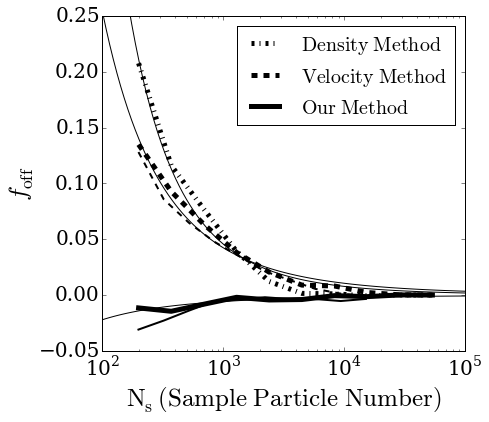

In [17]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)
plt.plot(bol_n_part_int, bol_median_dens_conc, label=r'$\mathrm{Density\ Method}$', linewidth=5, linestyle='-.', color='black')
plt.plot(bol_n_part_int, bol_median_vlct_conc, label=r'$\mathrm{Velocity\ Method}$', linewidth=5, linestyle='--', color='black')
plt.plot(n_part_int, median_vlct_conc, linewidth=2, linestyle='--', color='black')
plt.plot(bol_n_part_int, bol_median_mass_conc, label=r'$\mathrm{Our\ Method}$', linewidth=5, linestyle='-', color='black')
plt.plot(n_part_int, median_mass_conc, linewidth=2, linestyle='-', color='black')

log_n_sample = np.linspace(2.0, 5.0, 100)

    
popt_dens, pcov = curve_fit(func, np.log10(bol_n_part_int), bol_median_dens_conc)
plt.plot(10**log_n_sample, popt_dens[0]/(1+log_n_sample)**popt_dens[1], color='black')
print "dens", popt_dens, np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1])

popt_vel, pcov = curve_fit(func, np.log10(bol_n_part_int), bol_median_vlct_conc)
plt.plot(10**log_n_sample, popt_vel[0]/(1+log_n_sample)**popt_vel[1], color='black')
print "vel", popt_vel, np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1])

popt_mass, pcov = curve_fit(func, np.log10(bol_n_part_int), bol_median_mass_conc)
plt.plot(10**log_n_sample, popt_mass[0]/(1+log_n_sample)**popt_mass[1], color='black')
print "mass", popt_mass, np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1])

plt.xscale('log')
plt.xlim([1.0E2,1E5])
plt.ylim([-0.05, 0.25])
ax.set_ylabel(r'$f_{\mathrm{off}}$',fontsize=25)
ax.set_xlabel('$\mathrm{N_{s}\ (Sample\ Particle\ Number)}$',fontsize=25)
#ax.text(5E3, 0.12, r'$\mathrm{Bolshoi\ Sim.}$', fontsize=25)
ax.legend(loc=1, borderaxespad=0.5, prop={'size':20}, scatterpoints=1)
plt.savefig('../paper/avg_foff_bolshoi.pdf', bbox_inches='tight')

## Mass-concentration relationship

In [19]:
data_dens_bolshoi = np.loadtxt("../data/results/Bolshoi/density/results.dat")
data_vel_bolshoi = np.loadtxt("../data/results/Bolshoi/velocity/results.csv", delimiter=',')
data_mass_bolshoi = np.loadtxt("../data/results/Bolshoi/mass/results.csv", delimiter=',')

id_dens_bolshoi = np.int_(data_dens_bolshoi[:,0])
id_vel_bolshoi = np.int_(data_vel_bolshoi[:,0])
id_mass_bolshoi = np.int_(data_mass_bolshoi[:,0])

relaxed = data_dens_bolshoi[:,5]<0.05
print len(relaxed)
#density data

conc_bolshoi_density = data_dens_bolshoi[relaxed,3] / data_dens_bolshoi[relaxed,1] 
halo_mass_density = data_dens_bolshoi[relaxed,4] * 1E10 

bolshoi_particle_mass = 1.35E8 # Msun/h

# velocity data
ii = np.in1d(id_vel_bolshoi,id_dens_bolshoi)
conc_bolshoi_vel = data_vel_bolshoi[relaxed,1]
halo_mass_vel = data_vel_bolshoi[relaxed,2] * bolshoi_particle_mass

# mass data
ii = np.in1d(id_mass_bolshoi,id_dens_bolshoi)
conc_low_bolshoi_mass = data_mass_bolshoi[relaxed,1]
conc_bolshoi_mass = data_mass_bolshoi[relaxed,2]
conc_up_bolshoi_mass = data_mass_bolshoi[relaxed,3]
bolshoi_npart = data_mass_bolshoi[relaxed,4]
halo_mass_mass = data_mass_bolshoi[relaxed,4] * bolshoi_particle_mass

64531


In [20]:
n_bins = 9
log_mass_interval = np.linspace(10.4,14.5,n_bins)

mid_log_mass_interval = 0.5*(log_mass_interval[1:] + log_mass_interval[:-1])
mid_log_mass_interval =  log_mass_interval[:-1]

conc_median = np.ones((n_bins-1,3))
conc_up = np.ones((n_bins-1,3))
conc_down = np.ones((n_bins-1,3))

conc_median[:,0], conc_down[:,0], conc_up[:,0] = get_stats(np.log10(halo_mass_density), conc_bolshoi_density, log_mass_interval)
conc_median[:,1], conc_down[:,1], conc_up[:,1] = get_stats(np.log10(halo_mass_vel), conc_bolshoi_vel, log_mass_interval)
conc_median[:,2], conc_down[:,2], conc_up[:,2] = get_stats(np.log10(halo_mass_mass), conc_bolshoi_mass, log_mass_interval)

17777
10533
4137
1484
419
125
27
17334
10762
4271
1540
438
130
27
17334
10762
4271
1540
438
130
27


z 7.12533042504 -0.0719971449317


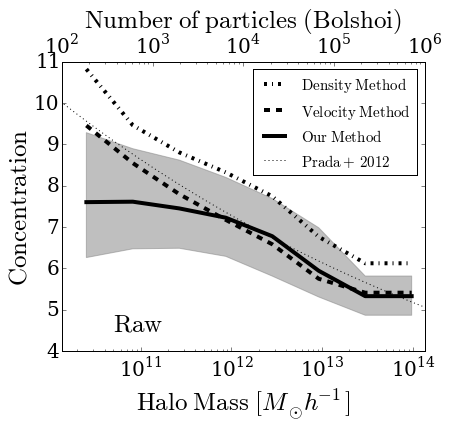

In [55]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

estilos = ['-.', '--', '-']
colores = ['blue', 'green', 'red']
origen = ['$\mathrm{Density\ Method}$','$\mathrm{Velocity\ Method}$','$\mathrm{Our\ Method}$']
for i in range(3):
    ax.plot(10**mid_log_mass_interval,conc_median[:,i],'black',lw=4,linestyle=estilos[i], label=origen[i])

ax.fill_between(10**mid_log_mass_interval,conc_down[:,2], conc_up[:,2], alpha=0.5, color='gray')

#for i in range(3):

#ax.plot(10**mid_log_mass_interval_MD,conc_median_MD[:,2],'blue',lw=4,linestyle=estilos[2])
#ax.fill_between(10**mid_log_mass_interval_MD,conc_down_MD[:,2], conc_up_MD[:,2], color='blue', alpha=0.2)
    
#datos de prada
log_mass_range = np.linspace(9.0, 15.0, 100)
conc_theory = 7.28 * (10**log_mass_range/(1.0E12))**-0.074
ax.plot(10**log_mass_range, conc_theory,label='$\mathrm{Prada+\ 2012}$', linestyle=':', color='black')


#fit
z = np.polyfit((mid_log_mass_interval[3:] - 12.0), np.log10(conc_median[3:,2]), 1)
print "z", 10**z[1], z[0]

#datos del fit
# log_mass_range = np.linspace(10.0, 15.0, 100)
# conc_theory = 10**z[1]*(10**log_mass_range/(1E12))**z[0]
# ax.plot(10**log_mass_range, conc_theory,label='$\mathrm{nuestro}$')

min_part = 1E2
max_part = 1E6
ax.legend(loc=1, borderaxespad=0.5, prop={'size':15})
plt.xlim([min_part*bolshoi_particle_mass,max_part*bolshoi_particle_mass])
#ax.plot(mid_log_mass_interval-np.log10(particle_mass),conc_median[:,0], lw=0)
ax.set_ylim([4,10.0])
#ax.set_yscale('log')

ax2 = ax.twiny()
enlarge_labels(ax2,20)

plt.subplots_adjust(bottom=0.18, top=0.85)
ax2.set_xscale('log')
ax2.set_xlim([min_part,max_part])
ax2.set_ylim([4,11.0])

ax2.set_xlabel('$\mathrm{Number\ of\ particles\ (Bolshoi)}$',fontsize=25)
ax.set_xscale('log')
ax.set_xlabel('$\mathrm{Halo\ Mass}\ [M_{\odot} h^{-1}]$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration}$',fontsize=25)
ax.text(5E10, 4.5, r'$\mathrm{Raw}$', fontsize=25)
plt.savefig('../paper/concentration_bolshoi.pdf', bbox_inches='tight')


[ 0.14873205  0.06001083  0.02717832  0.01345994  0.00715828  0.00403475
  0.00238677  0.00147071]
[-0.01484934 -0.0075449  -0.00417854 -0.00247378 -0.00154448 -0.00100701
 -0.00068068 -0.00047432]
z 6.77514640154 -0.0520484177946


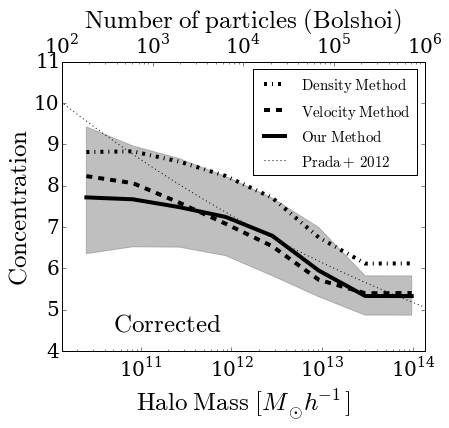

In [56]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)

estilos = ['-.', '--', '-']
colores = ['blue', 'green', 'red']
origen = ['$\mathrm{Density\ Method}$','$\mathrm{Velocity\ Method}$','$\mathrm{Our\ Method}$']

min_i = 0
mid_log_n_particle = mid_log_mass_interval - np.log10(bolshoi_particle_mass)
#density
i=0
f_off = func(mid_log_n_particle, popt_dens[0], popt_dens[1])
ax.plot(10**mid_log_mass_interval[min_i:],conc_median[min_i:,i]/(1.0+f_off[min_i:]),'black',lw=4,linestyle=estilos[i], label=origen[i])

#velocity
i=1
f_off = func(mid_log_n_particle, popt_vel[0], popt_vel[1])
ax.plot(10**mid_log_mass_interval[min_i:],conc_median[min_i:,i]/(1.0+f_off[min_i:]),'black',lw=4,linestyle=estilos[i], label=origen[i])
print f_off

#mass
i=2
f_off = func(mid_log_n_particle, popt_mass[0], popt_mass[1])
ax.plot(10**mid_log_mass_interval[min_i:],conc_median[min_i:,i]/(1.0+f_off[min_i:]),'black',lw=4,linestyle=estilos[i], label=origen[i])
ax.fill_between(10**mid_log_mass_interval[min_i:],conc_down[min_i:,2]/(1.0+f_off[min_i:]), 
                conc_up[min_i:,2]/(1.0+f_off[min_i:]), color='gray', alpha=0.5)

print f_off

    
#datos de prada
log_mass_range = np.linspace(9.0, 15.0, 100)
conc_theory = 7.28 * (10**log_mass_range/(1.0E12))**-0.074
ax.plot(10**log_mass_range, conc_theory,label='$\mathrm{Prada+\ 2012}$', linestyle=':', color='black')


#fit
z = np.polyfit((mid_log_mass_interval[:] - 12.0), np.log10(conc_median[:,2]/(1+f_off)), 1)
print "z", 10**z[1], z[0]

min_part = 1E2
max_part = 1E6
ax.legend(loc=1, borderaxespad=0.5, prop={'size':15})
plt.xlim([min_part*bolshoi_particle_mass,max_part*bolshoi_particle_mass])
#ax.plot(mid_log_mass_interval-np.log10(particle_mass),conc_median[:,0], lw=0)
ax.set_ylim([4,11.0])
#ax.set_yscale('log')

ax2 = ax.twiny()
enlarge_labels(ax2,20)

plt.subplots_adjust(bottom=0.18, top=0.85)
ax2.set_xscale('log')
ax2.set_xlim([min_part,max_part])
ax2.set_ylim([4,11.0])

ax2.set_xlabel('$\mathrm{Number\ of\ particles\ (Bolshoi)}$',fontsize=25)
ax.set_xscale('log')
ax.set_xlabel('$\mathrm{Halo\ Mass}\ [M_{\odot} h^{-1}]$',fontsize=25)
ax.set_ylabel('$\mathrm{Concentration}$',fontsize=25)

ax.text(5E10, 4.5, r'$\mathrm{Corrected}$', fontsize=25)
plt.savefig('../paper/concentration_bolshoi_corrected.pdf', bbox_inches='tight')

## 1-sigma uncertainties

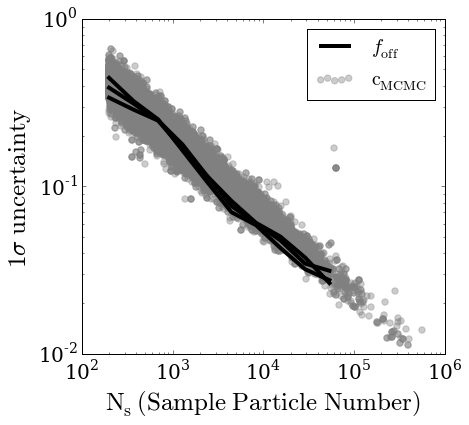

In [57]:
fig = plt.figure(figsize=(6.5,6.0))
ax = plt.axes()

enlarge_labels(ax,20)
#plt.plot(bol_n_part_int, bol_high_dens_conc - bol_low_dens_conc, label=r'$f_{\rm{off}}\ \mathrm{Density\ Method}$', linewidth=4, linestyle='-.')
#plt.plot(bol_n_part_int, bol_high_vlct_conc - bol_low_vlct_conc, label=r'$f_{\rm{off}}\ \mathrm{Velocity\ Method}$', linewidth=4, linestyle='--')
plt.plot(bol_n_part_int, bol_high_dens_conc - bol_low_dens_conc, 
             linewidth=4, linestyle='-', color='black')
plt.plot(bol_n_part_int, bol_high_vlct_conc - bol_low_vlct_conc, 
         linewidth=4, linestyle='-', color='black')
plt.plot(bol_n_part_int, bol_high_mass_conc - bol_low_mass_conc, label=r'$f_{\rm{off}}$', 
         linewidth=4, linestyle='-', color='black')


conc_low_bolshoi_mass = data_mass_bolshoi[relaxed,1]
conc_bolshoi_mass = data_mass_bolshoi[relaxed,2]
conc_up_bolshoi_mass = data_mass_bolshoi[relaxed,3]

n_points = len(bolshoi_npart)
ii = np.random.choice(np.arange(n_points), int(n_points/1))
plt.scatter(bolshoi_npart[ii], np.sqrt(bolshoi_npart[ii])*(conc_up_bolshoi_mass[ii] - conc_low_bolshoi_mass[ii])/conc_bolshoi_mass[ii], 
            s=40, label=r'$\rm{c_{MCMC}}$', alpha=0.4, color='gray')


plt.xscale('log')
plt.yscale('log')
plt.xlim([1.0E2,1E6])
plt.ylim([1E-2, 1.0])
ax.set_ylabel(r'$1\sigma\ {\rm{uncertainty}}$',fontsize=25)
ax.set_xlabel('$\mathrm{N_{s}\ (Sample\ Particle\ Number)}$',fontsize=25)
#ax.text(5E3, 0.12, r'$\mathrm{Bolshoi\ Sim.}$', fontsize=25)
ax.legend(loc=1, borderaxespad=0.5, prop={'size':20}, scatterpoints=5)
plt.savefig('../paper/sigma_foff_bolshoi.pdf', bbox_inches='tight')